In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.linear_model import LogisticRegression

In [3]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn import linear_model
import pickle

In [4]:
import imblearn


In [5]:
def dataPreprocessing(filepath):

    print('reading hdf5')
    dfinal = pd.read_hdf(filepath)
    #dfinal = pd.read_pkl(filepath)

    print("Current Time =", datetime.now().strftime("%H:%M:%S"))


    dfSorted = dfinal.sort_values(by = ['date','model'])

    dfSorted = dfinal.sort_values(by = ['date','model'])

    dfSorted['modelName'] = dfSorted['model']

    dfModels = dfinal['model'].drop_duplicates().reset_index()
    dfModels['modelType'] = dfModels.index

    dfSorted = pd.merge(left = dfSorted,right = dfModels, how='left', left_on='model',right_on = 'model')

  

    models = list(dfModels['model'])

    newModelsList=[]
    
    df_fail = dfSorted[dfSorted.failure==1]

    #filter out Models without any failure

    for item in models:
        df_model_fail = df_fail[df_fail.model==item]
        #df_model_success = df_success[df_success.model == item]
        if len(df_model_fail)>0:
            newModelsList.append(item)


    #newModelsList = ['ST4000DM000', 'ST12000NM0007', 'HGST HMS5C4040ALE640', 'ST8000NM0055', 'ST8000DM002', 'HGST HMS5C4040BLE640', 'TOSHIBA MG07ACA14TA', 'HGST HUH721212ALN604', 'HGST HUH721212ALE600', 'TOSHIBA MQ01ABF050', 'ST500LM030', 'ST6000DX000', 'ST10000NM0086', 'TOSHIBA MQ01ABF050M', 'WDC WD5000LPVX', 'ST500LM012 HN', 'HGST HUH728080ALE600', 'ST8000DM005', 'Seagate BarraCuda SSD ZA500CM10002', 'ST12000NM0117']

    print(newModelsList)


    df_updated = dfSorted[dfSorted['model'].isin(newModelsList)]

    #print(df_updated.head(),len(df_updated) )




    #df_updated.to_hdf(preprocessedDataPath, key='dfinal', mode='w')

    print('done ')
    print("Current Time =", datetime.now().strftime("%H:%M:%S"))
    return df_updated

In [6]:
import datetime
from datetime import datetime
print("Current Time =", datetime.now().strftime("%H:%M:%S"))
#df_updated = dataPreprocessing()
#simpleFeatures = ['modelType','serial_number','failure','capacity_bytes','smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw', 'smart_240_raw','smart_241_raw']

#df_updated = pd.read_hdf("~/data/df_Updated.h5")
df_updated = dataPreprocessing("~/data/hdd_2_2019.h5")
dfModels = pd.read_csv("~/data/modelList.csv")
dffeatureDict = pd.read_csv("~/data/smartFeaturesDict.csv")

Current Time = 03:56:10
reading hdf5
Current Time = 03:56:17
['ST4000DM000', 'ST12000NM0007', 'HGST HMS5C4040ALE640', 'ST8000NM0055', 'ST8000DM002', 'HGST HMS5C4040BLE640', 'HGST HUH721212ALN604', 'HGST HUH721212ALE600', 'TOSHIBA MQ01ABF050', 'ST500LM030', 'ST6000DX000', 'ST10000NM0086', 'TOSHIBA MQ01ABF050M', 'WDC WD5000LPVX', 'ST500LM012 HN', 'HGST HUH728080ALE600', 'TOSHIBA HDWF180']
done 
Current Time = 03:57:30


In [7]:
df_updated['modelType1'] = df_updated['modelType']

In [8]:
df_hdd = df_updated[pd.isnull(df_updated.smart_173_raw)]

In [9]:
df_ssd = df_updated[pd.notnull(df_updated.smart_173_raw)]

In [10]:
print(len(df_hdd), len(df_ssd))

9683405 0


In [11]:
print(len(df_ssd[df_ssd.failure==1]),len(df_hdd[df_hdd.failure==1]))

0 513


In [12]:
dfstat = df_hdd.describe()

In [13]:
def pickleToHdfConvert(filepathPkl,filepathHdf):
    df = pd.read_pickle(filepathPkl)
    df.to_hdf(filepathHdf, key='df', mode='w')

#pickleToHdfConvert("~/data/hdd_3_2019.pkl","~/data/hdd_3_2019.h5")

In [14]:
ds = df_hdd

In [15]:
dfFailures = ds[ds.failure==1]
dfSuccess = ds[ds.failure==0].sample(n = 100000)
dfsample =  pd.concat([dfSuccess, dfFailures], axis=0)

In [16]:

dstrain = dfsample[dfsample.capacity_bytes>0]


print(len(dstrain[dstrain.failure==0]),len(dstrain[dstrain.failure==1]),len(dstrain) )

#Y = dstrain[['failure']]

#X = dstrain[simpleFeatures]

99997 513 100510


In [17]:
print(len(dfSuccess))

100000


In [18]:
dstrain.columns

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized',
       'smart_2_raw', 'smart_3_normalized',
       ...
       'smart_252_normalized', 'smart_252_raw', 'smart_254_normalized',
       'smart_254_raw', 'smart_255_normalized', 'smart_255_raw', 'modelName',
       'index', 'modelType', 'modelType1'],
      dtype='object', length=133)

In [19]:
df1 = dfFailures[['date','model','failure']].groupby(by = ['model']).count()
dfmodelFailed = pd.DataFrame(dstrain[dstrain.failure==1].groupby(by = ['model']).count()[['modelType','failure']])

In [20]:
df2 = df1[df1.failure>=19]
df3 = df2.copy()
df3['model'] = df2.index

In [21]:
print(df3)

               date  failure          model
model                                      
ST12000NM0007   247      247  ST12000NM0007
ST4000DM000     104      104    ST4000DM000
ST8000DM002      25       25    ST8000DM002
ST8000NM0055     64       64   ST8000NM0055


In [22]:
modelFailed = list(df3['model'])

In [23]:
print(modelFailed)

['ST12000NM0007', 'ST4000DM000', 'ST8000DM002', 'ST8000NM0055']


In [24]:
#simpleFeatures = ['capacity_bytes','modelType','smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw','smart_200_raw', 'smart_240_raw','smart_241_raw']
simpleFeaturesHist = ['capacity_bytes','smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw','smart_200_raw', 'smart_240_raw','smart_241_raw']
simpleFeatures = ['capacity_bytes','smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw','smart_200_raw', 'smart_240_raw','smart_241_raw']
smartFeatures = ['smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw','smart_200_raw', 'smart_240_raw','smart_241_raw']





In [25]:
#dstrain= dstrain[dstrain.model.isin(modelFailed)]
dstrain= dstrain

In [26]:
newFeatureArr=[]
for item in simpleFeatures:
    arr = item.split('_')
    if item=='capacity_bytes':
        id=0
    else:
        id =arr[1]
    newFeatureArr.append(  [id,item] )

featureDict = pd.DataFrame(newFeatureArr)
    

In [27]:
featureDict1 = featureDict.rename(columns={0:'id',1:'name'})

In [28]:
print(len(dstrain))

100510


In [29]:
dfFailures = dstrain[dstrain.failure==1]
dfSuccess = dstrain[dstrain.failure==0]

In [30]:
import matplotlib.pyplot as plt

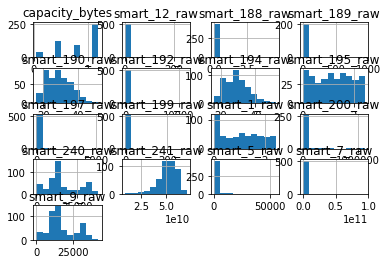

In [31]:
dfFailures[simpleFeaturesHist].hist()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f577f616198>,
      dtype=object)

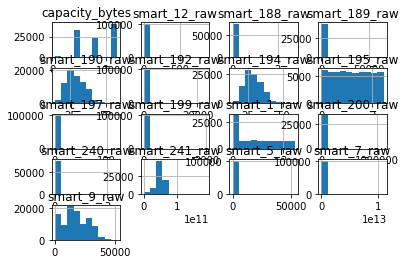

In [32]:
dfSuccess[simpleFeaturesHist].hist()

In [33]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

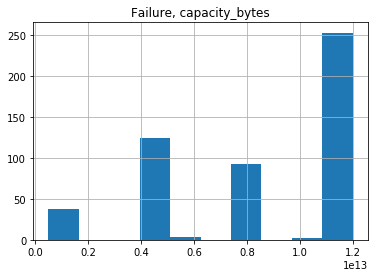

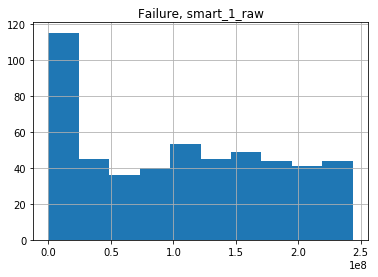

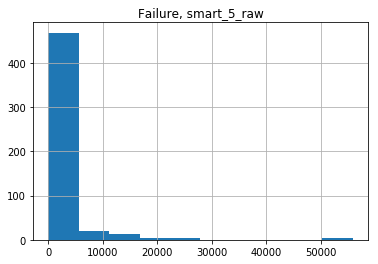

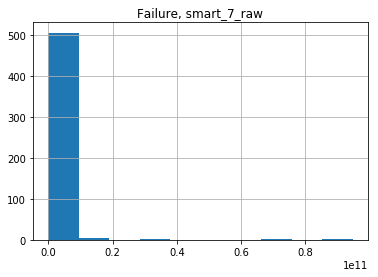

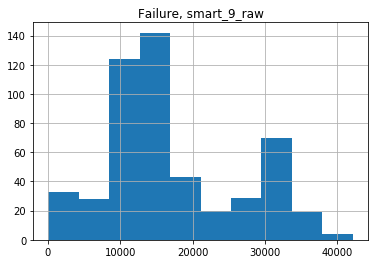

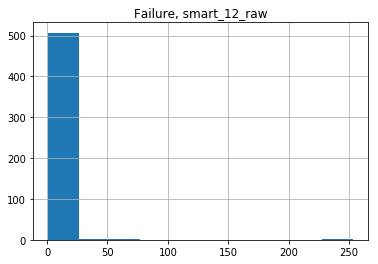

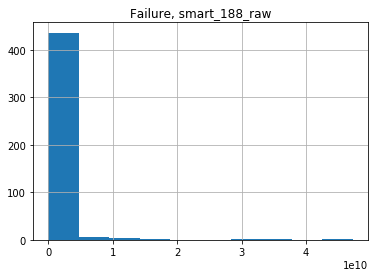

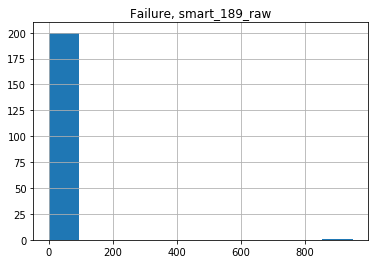

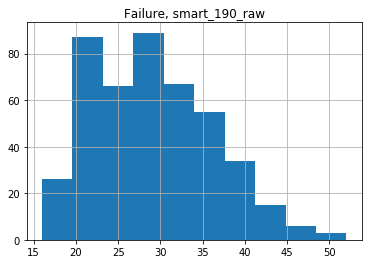

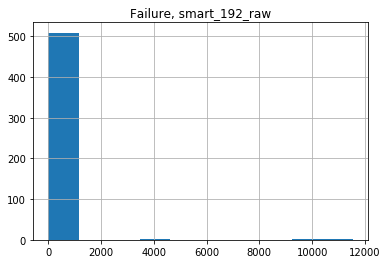

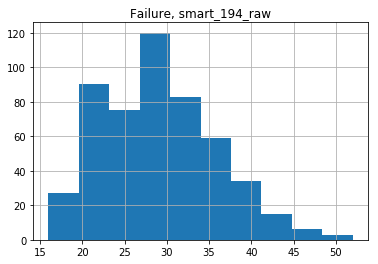

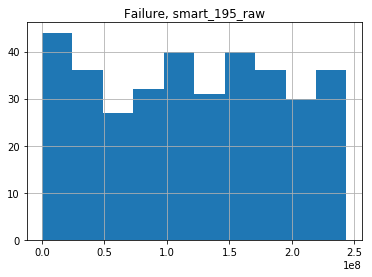

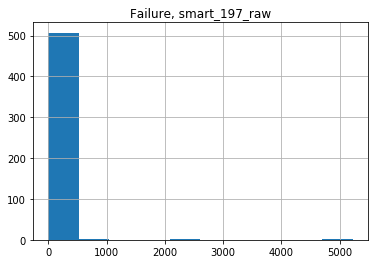

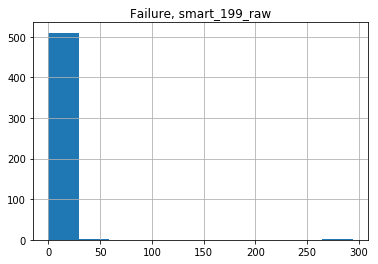

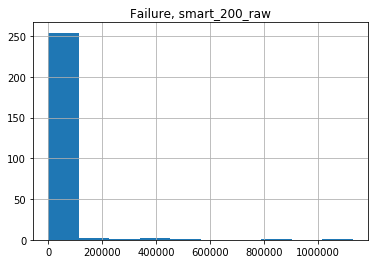

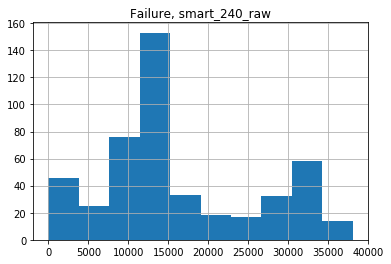

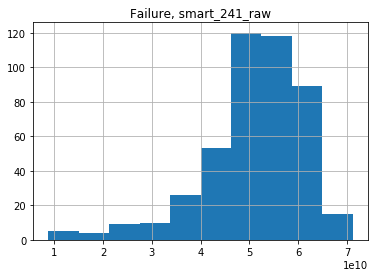

In [34]:

for item in simpleFeaturesHist:
    dfFailures[item].hist()
    plt.title('Failure, '+ str(item))

    #dfSuccess[item].hist()
    #plt.title('NON - Failure, '+ str(item))
    plt.show()
#counts, bins = np.histogram(dfFailures[['smart_194_raw']])
#plt.hist(bins[:-1], bins, weights=counts)
#plt.hist(dfFailures[['smart_194_raw']].dropna(), 50, density=True, facecolor='g', alpha=0.75)
#plt.show()

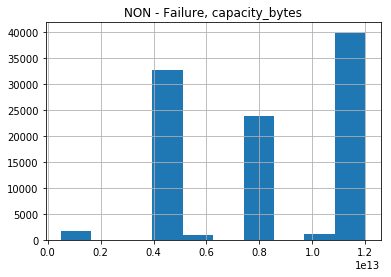

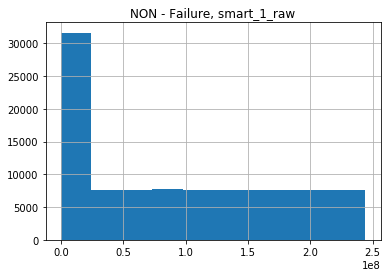

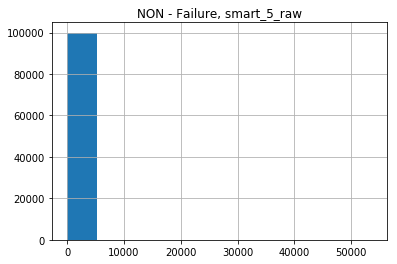

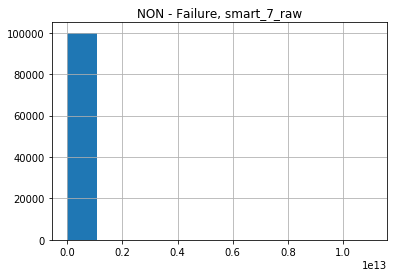

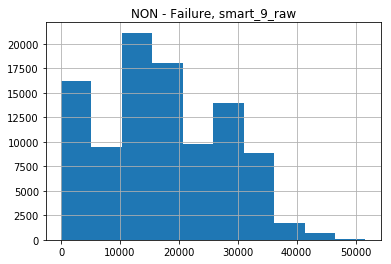

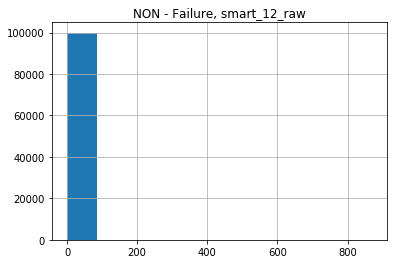

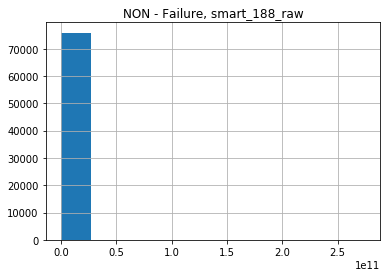

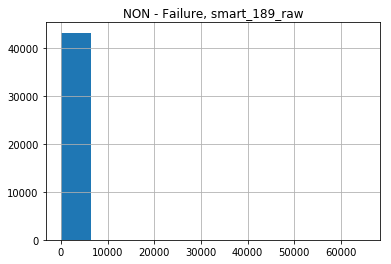

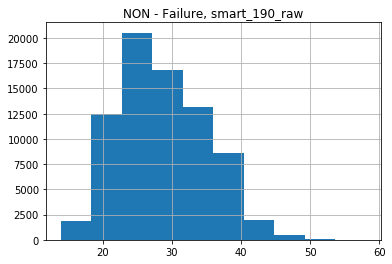

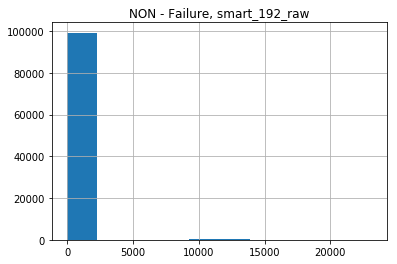

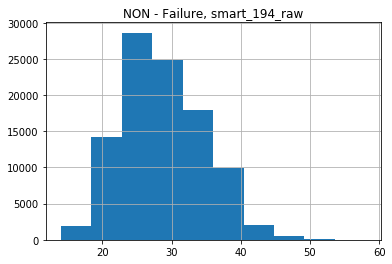

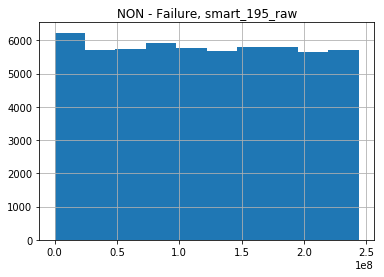

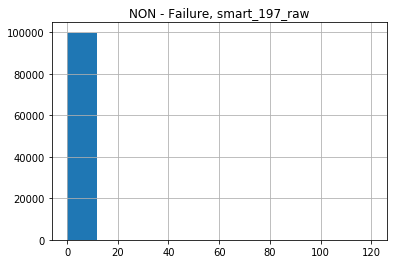

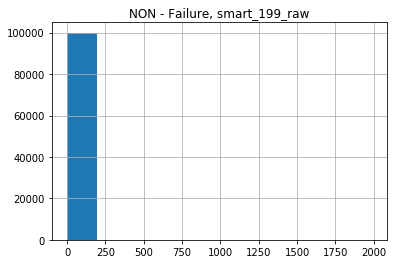

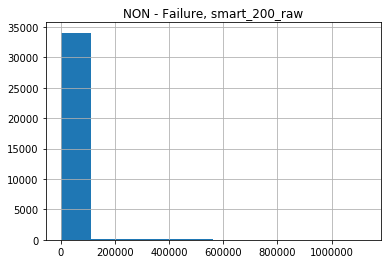

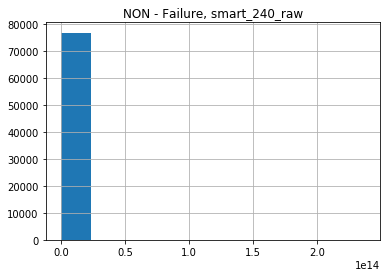

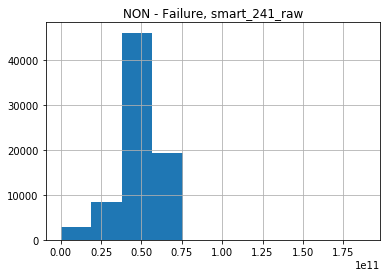

In [35]:
for item in simpleFeaturesHist:
   # dfFailures[item].hist()
    #plt.title('Failure, '+ str(item))

    dfSuccess[item].hist()
    plt.title('NON - Failure, '+ str(item))
    plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f577f545978>]],
      dtype=object)

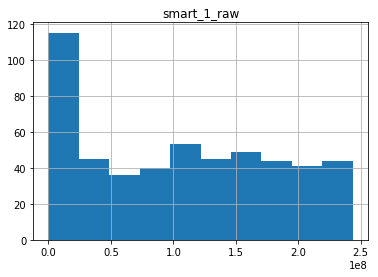

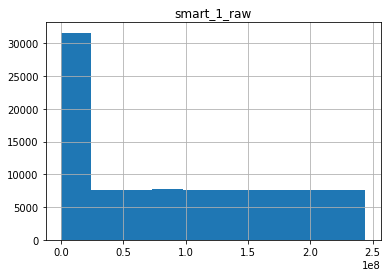

In [36]:
dfFailures[['smart_1_raw']].hist()
dfSuccess[['smart_1_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f577f05e6a0>]],
      dtype=object)

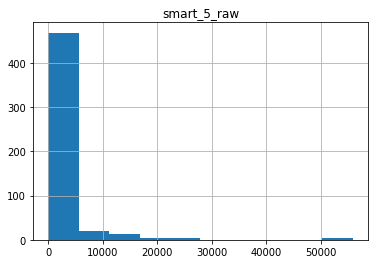

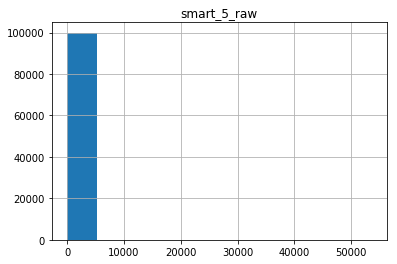

In [37]:
dfFailures[['smart_5_raw']].hist()
dfSuccess[['smart_5_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f577f908710>]],
      dtype=object)

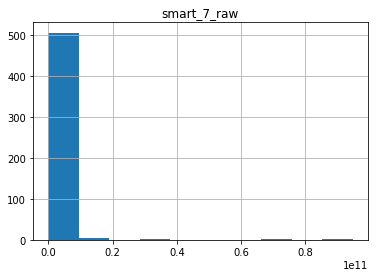

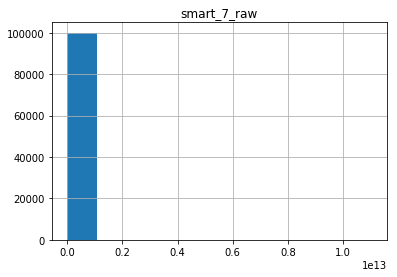

In [38]:
dfFailures[['smart_7_raw']].hist()
dfSuccess[['smart_7_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f577f9ae7f0>]],
      dtype=object)

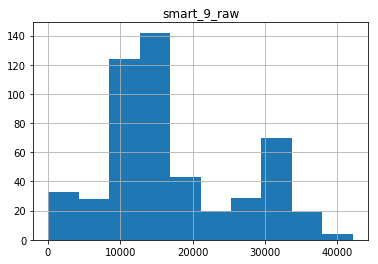

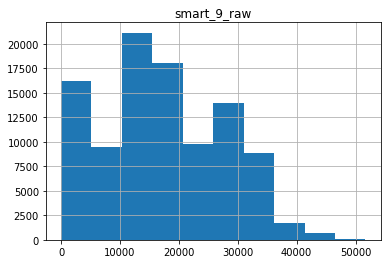

In [39]:
dfFailures[['smart_9_raw']].hist()
dfSuccess[['smart_9_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f577f620278>]],
      dtype=object)

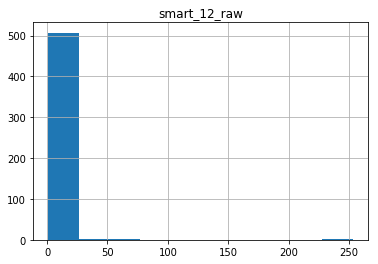

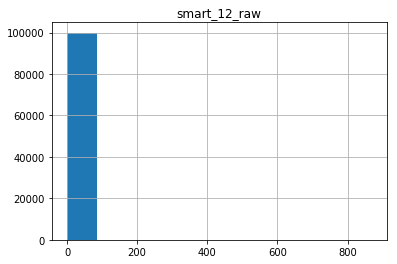

In [40]:
dfFailures[['smart_12_raw']].hist()
dfSuccess[['smart_12_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f577ef39b70>]],
      dtype=object)

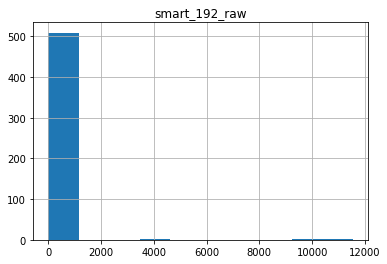

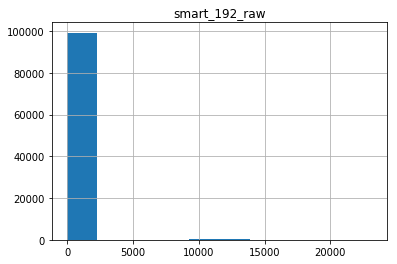

In [41]:
dfFailures[['smart_192_raw']].hist()
dfSuccess[['smart_192_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f577f7609e8>]],
      dtype=object)

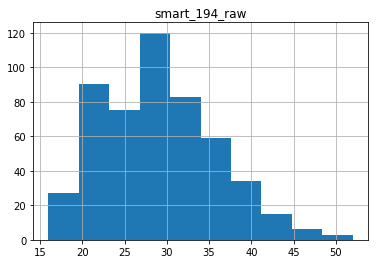

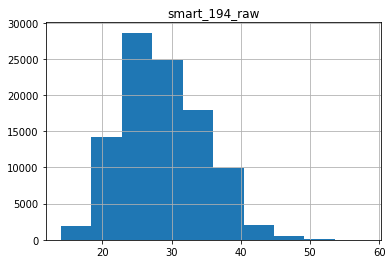

In [42]:
dfFailures[['smart_194_raw']].hist()
dfSuccess[['smart_194_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f577f612f98>]],
      dtype=object)

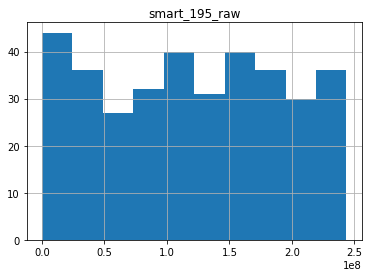

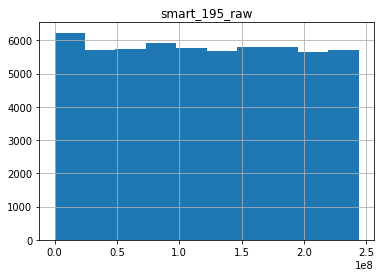

In [43]:
dfFailures[['smart_195_raw']].hist()
dfSuccess[['smart_195_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f577f677cc0>]],
      dtype=object)

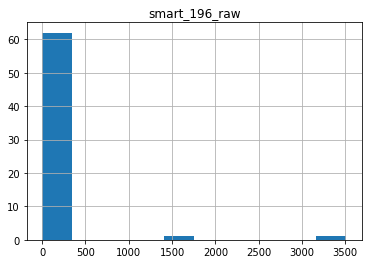

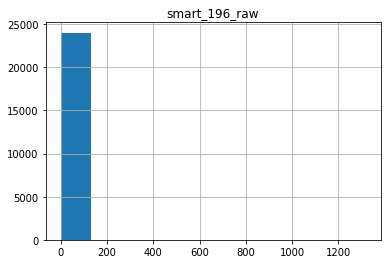

In [44]:
dfFailures[['smart_196_raw']].hist()
dfSuccess[['smart_196_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f577ef70ac8>]],
      dtype=object)

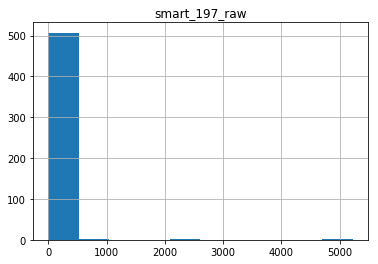

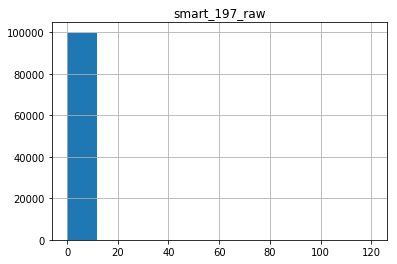

In [45]:
dfFailures[['smart_197_raw']].hist()
dfSuccess[['smart_197_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f577ed4a3c8>]],
      dtype=object)

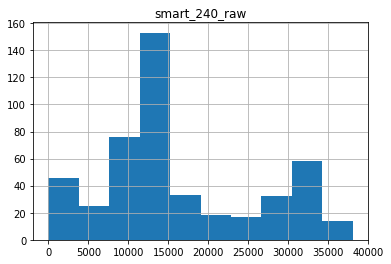

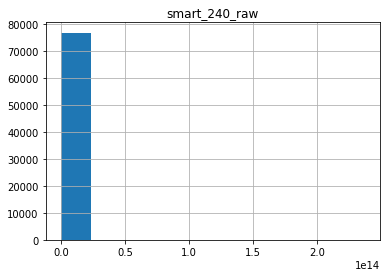

In [46]:
dfFailures[['smart_240_raw']].hist()
dfSuccess[['smart_240_raw']].hist()

Text(0.5, 1.0, 'Non-fail, Total LBAs Written')

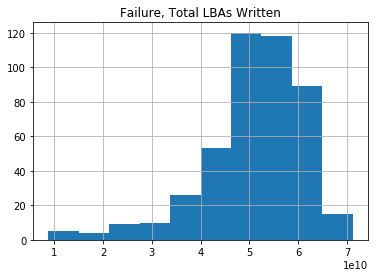

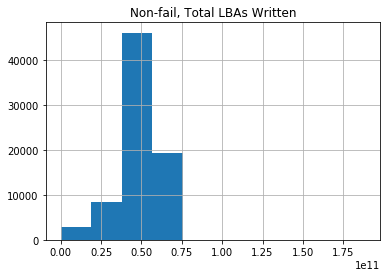

In [106]:
dfFailures[['smart_241_raw']].hist()
#plt.title('Failure, '+ str(item))
plt.title('Failure, Total LBAs Written')


dfSuccess[['smart_241_raw']].hist()
plt.title('Non-fail, Total LBAs Written')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f577f94dcc0>]],
      dtype=object)

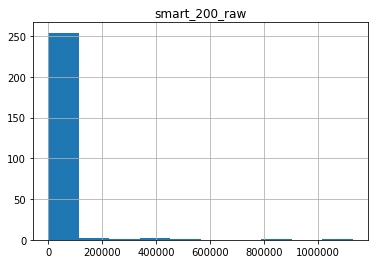

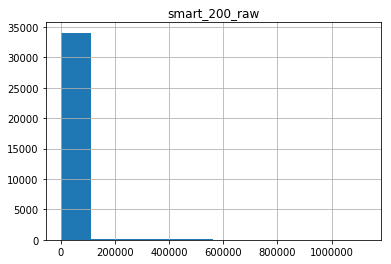

In [48]:
dfFailures[['smart_200_raw']].hist()
dfSuccess[['smart_200_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f577f7e9b70>]],
      dtype=object)

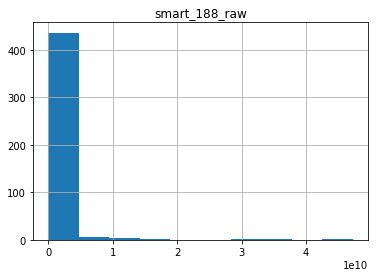

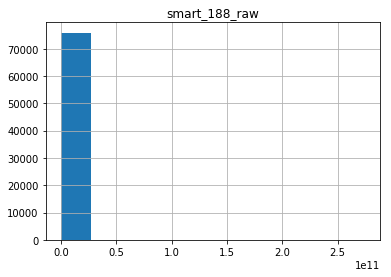

In [49]:
dfFailures[['smart_188_raw']].hist()
dfSuccess[['smart_188_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f577ed5d518>]],
      dtype=object)

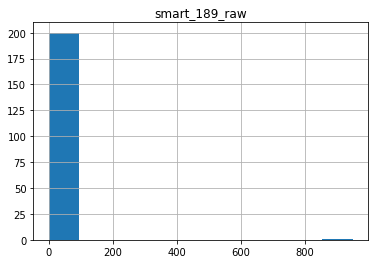

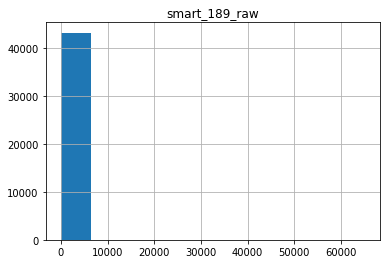

In [50]:
dfFailures[['smart_189_raw']].hist()
dfSuccess[['smart_189_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f577ec3fe80>]],
      dtype=object)

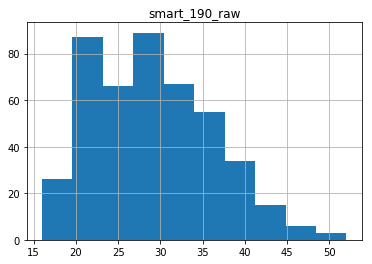

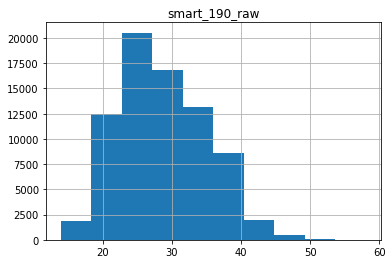

In [51]:
dfFailures[['smart_190_raw']].hist()
dfSuccess[['smart_190_raw']].hist()

In [52]:
dstrain.columns

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized',
       'smart_2_raw', 'smart_3_normalized',
       ...
       'smart_252_normalized', 'smart_252_raw', 'smart_254_normalized',
       'smart_254_raw', 'smart_255_normalized', 'smart_255_raw', 'modelName',
       'index', 'modelType', 'modelType1'],
      dtype='object', length=133)

In [53]:
eda_fail = pd.DataFrame(dfFailures[simpleFeaturesHist].describe())
eda_success = pd.DataFrame(dfSuccess[simpleFeaturesHist].describe())

In [54]:
eda_fail.to_csv("~/data/eda_fail.csv")
eda_success.to_csv("~/data/eda_success.csv")

In [55]:
from imblearn.over_sampling import SMOTE

In [56]:
Y = dstrain[['failure']]

X = dstrain[simpleFeatures]


X_train0 = X
y_train0 = Y

print("Number transactions X_train dataset: ", X_train0.shape)
print("Number transactions y_train dataset: ", y_train0.shape)


print("Current Time =", datetime.now().strftime("%H:%M:%S"))

X_train = X_train0.fillna(0)




print('Handling imbalanced data - starting SMOTE ...')


def overSamplingWithSMOTE(X_train,y_train0):
    sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

    #convert pandas to array
    y_train = np.array(y_train0.failure)

    #Create final training dataset
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    return X_train_res, y_train_res


X_train_res, y_train_res = overSamplingWithSMOTE(X_train,y_train0)

Number transactions X_train dataset:  (100510, 17)
Number transactions y_train dataset:  (100510, 1)
Current Time = 03:59:11
Handling imbalanced data - starting SMOTE ...


In [57]:
import seaborn


In [58]:
def readingTestDataset(filepath, dfModels, features, models):
    dsTest0 = pd.read_hdf(filepath)
    dsTest = dsTest0[dsTest0.capacity_bytes > 0]
    dsTest = pd.merge(left=dsTest, right=dfModels, how='left', left_on='model', right_on='model')
    
    #dsTest = dsTest[dsTest.model.isin(models)]
    # validate for another quarter
    
    #filtering out SSD
    dsTest = dsTest[pd.isnull(dsTest.smart_173_raw)]
    
    

    #filter out Models without any failure   
    
    Xtest = dsTest[features]
    Ytest = dsTest[['failure']]
    X1test = Xtest.fillna(0)

    return X1test, Ytest

In [59]:
%time    Xtest,Ytest = readingTestDataset("~/data/hdd_3_2019.h5",dfModels, simpleFeatures,modelFailed)


CPU times: user 42.2 s, sys: 25.7 s, total: 1min 7s
Wall time: 57.3 s


In [60]:
print(len(y_train_res))
y_res =  pd.DataFrame(y_train_res).rename(columns = {0:'fail'})
print(len(y_res), len(y_res[y_res.fail==1]),len(y_res[y_res.fail==0]) ,len(y_res[y_res.fail==1])/len(y_res[y_res.fail==0]) )

199994
199994 99997 99997 1.0


In [61]:
def logisticRegression(X_train_res, y_train_res, Xtest, Ytest):
#   clf2 = LogisticRegression(penalty = 'l2', solver = 'saga',tol = 1e-6).fit(X_train_res, y_train_res)
    clf2 = LogisticRegression(C=0.05).fit(X_train_res, y_train_res)

    #(penalty = 'l1', solver = 'liblinear',tol = 1e-6, max_iter = int(1e6),warm_start = True,intercept_scaling = 10000.)

    #predictions2 = clf2.predict(Xtest)

    filename = 'finalized_model!.sav'
    pickle.dump(clf2, open(filename, 'wb'))
    return clf2

In [62]:
clf2 = logisticRegression(X_train_res, y_train_res, Xtest, Ytest)

(0, 1)

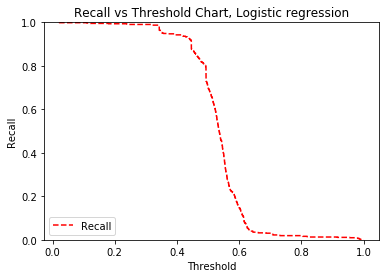

In [63]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(Ytest, clf2.predict_proba(Xtest)[:,1]) 
   #retrieve probability of being 1(in second column of probs_y)
#pr_auc = metrics.auc(recall, precision)

plt.title("Recall vs Threshold Chart, Logistic regression")
#plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

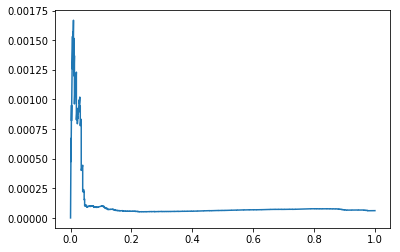

In [64]:
plt.plot( recall[: -1], precision[: -1], label="Precision v recall")

In [65]:
print(len(precision))

7542554


In [66]:
THRESHOLD=0.4
predictions3 = clf2.predict(Xtest)
predictions3_prob = clf2.predict_proba(Xtest)[:,1]
prob = pd.DataFrame(predictions3_prob)
true = pd.DataFrame(Ytest)
pred = pd.DataFrame(predictions3)

all = pd.merge(true,pred, how = 'left',right_index = True,left_index = True)
all = pd.merge(all,prob, how = 'left',right_index = True,left_index = True)
#all['pred_adj']
#print(all[all.failure==1])

#predictions3_adj = [1 if clf2.predict_proba(Xtest)[:,1] > THRESHOLD else 0 for x in clf2.predict_proba(Xtest)[:,1]]
print('results after over sampling, logistic regressioin, no device filtering')

print(classification_report(Ytest, predictions3))
print(confusion_matrix(Ytest, predictions3))
#print(classification_report(Ytest, predictions3_adj))
#print(confusion_matrix(Ytest, predictions3_adj))




results after over sampling, logistic regressioin, no device filtering
              precision    recall  f1-score   support

           0       1.00      0.40      0.58  10213572
           1       0.00      0.70      0.00       626

    accuracy                           0.40  10214198
   macro avg       0.50      0.55      0.29  10214198
weighted avg       1.00      0.40      0.58  10214198

[[4124796 6088776]
 [    186     440]]


In [67]:
#plt.plot( predictions3, predictions3_prob, label="Precision v probability")
predProb3 = round(pd.DataFrame(predictions3_prob),5).rename(columns = {0: 'probability'})
pred3 = pd.DataFrame(predictions3).rename(columns = {0: 'prediction'})
predLog = pd.merge(pred3,predProb3, how = 'left', right_index = True, left_index=True)

In [68]:
predLog.to_csv("~/data/prediction_LogReg1.csv")

In [69]:
yscore = clf2.decision_function(Xtest)


In [70]:
print(yscore)

[ 0.42175366 -0.03146765 -0.08157134 ... -0.65029329 -0.21680457
 -0.21680457]


In [71]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = metrics.roc_curve(Ytest, yscore, pos_label=0)


Text(0.5, 1.0, 'ROC, non-failures, 0.46')

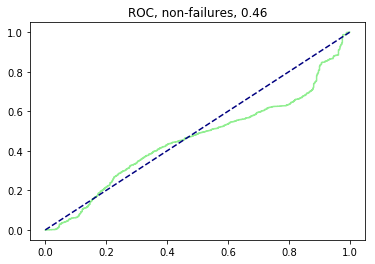

In [72]:
plt.plot(fpr,tpr,color='lightgreen')
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.title("ROC, non-failures, "+ str(round(auc( fpr,tpr),2)))

In [73]:
print(thresholds)

[   23.4837945     22.4837945     22.47006278 ... -1403.17580278
 -1417.21228708 -1608.00195657]


In [74]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
fpr1, tpr1, thresholds1 = metrics.roc_curve(Ytest, yscore, pos_label=1)

#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



Text(0.5, 1.0, 'ROC, failures, 0.54')

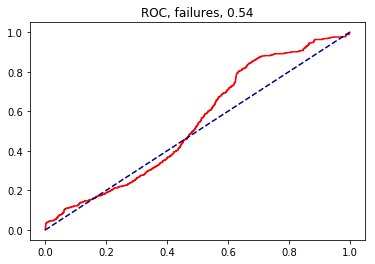

In [76]:
plt.plot(fpr1,tpr1,color='red')
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.title("ROC, failures, "+ str(round(auc(fpr1,tpr1),2)))

In [77]:
def randomForest(X_train_res, y_train_res):
    #Random forests
    print('starting random forest')
    clfRF = RandomForestClassifier(max_depth=12, random_state=0,max_samples=1000,n_estimators=80).fit(X_train_res, y_train_res)
    print('feature impoartance for RF')
    print(clfRF.feature_importances_)
    pd.DataFrame(clfRF.feature_importances_).to_csv("~/data/featuresSelection.csv")
    return clfRF

In [78]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
Xtrain_sc = sc.fit_transform(X_train_res)
Xtest_sc = sc.transform(Xtest)

In [79]:
clfRF = randomForest(X_train_res, y_train_res)
predictionRF = clfRF.predict(Xtest)
probabilityRF = clfRF.predict_proba(Xtest)

print(classification_report(Ytest, predictionRF))
print(confusion_matrix(Ytest, predictionRF))

starting random forest
feature impoartance for RF
[0.02682858 0.02643217 0.35322912 0.02814317 0.04689046 0.05548456
 0.01361373 0.00185889 0.02193214 0.04279903 0.03073473 0.01623446
 0.25674941 0.01063401 0.00698957 0.03420093 0.02724505]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98  10213572
           1       0.00      0.73      0.00       626

    accuracy                           0.97  10214198
   macro avg       0.50      0.85      0.49  10214198
weighted avg       1.00      0.97      0.98  10214198

[[9902838  310734]
 [    169     457]]


In [80]:
featureRank = pd.read_csv("~/data/featuresSelection.csv")

In [81]:
print(dffeatureDict)

     id                                               name
0     1                                    Read Error Rate
1     2                             Throughput Performance
2     3                                       Spin-Up Time
3     4                                   Start/Stop Count
4     5                          Reallocated Sectors Count
5     6                                Read Channel Margin
6     7                                    Seek Error Rate
7     8                              Seek Time Performance
8     9                                     Power-On Hours
9    10                                   Spin Retry Count
10   11   Recalibration Retries or Calibration Retry Count
11   12                                  Power Cycle Count
12   13                               Soft Read Error Rate
13   22                               Current Helium Level
14  170                           Available Reserved Space
15  171                             SSD Program Fail Cou

In [82]:
featureRank1 = featureRank.rename(columns={'0': 'rank'})
print(featureRank1.columns)

Index(['Unnamed: 0', 'rank'], dtype='object')


In [85]:
dffeatureDict1=dffeatureDict.rename(columns={'name':'fullName'})
print(dffeatureDict1.dtypes)
featureDict1['id'] = [int(x) for x in featureDict1['id']]
#print (featureDict1.head())

id           int64
fullName    object
dtype: object


In [86]:

#featureDict1
featureDict2 = pd.merge(featureDict1, dffeatureDict1, how = 'left', right_on = 'id', left_on = 'id').rename(columns={'name_x':'name'})
print(featureDict2)


     id            name                                           fullName
0     0  capacity_bytes                                                NaN
1     1     smart_1_raw                                    Read Error Rate
2     5     smart_5_raw                          Reallocated Sectors Count
3     7     smart_7_raw                                    Seek Error Rate
4     9     smart_9_raw                                     Power-On Hours
5    12    smart_12_raw                                  Power Cycle Count
6   188   smart_188_raw                                    Command Timeout
7   189   smart_189_raw                                    High Fly Writes
8   190   smart_190_raw      Temperature Difference or Airflow Temperature
9   192   smart_192_raw  Power-off Retract Count, Emergency Retract Cyc...
10  194   smart_194_raw                 Temperature or Temperature Celsius
11  195   smart_195_raw                             Hardware ECC Recovered
12  197   smart_197_raw  

In [98]:
featureRank1 = pd.merge(featureRank1, featureDict2, how = 'left', right_index = True, left_index = True).rename(columns = {'name_x':'name1'})
print(featureRank1)

    Unnamed: 0      rank  id_x           name1  \
0            0  0.026829     0  capacity_bytes   
1            1  0.026432     1     smart_1_raw   
2            2  0.353229     5     smart_5_raw   
3            3  0.028143     7     smart_7_raw   
4            4  0.046890     9     smart_9_raw   
5            5  0.055485    12    smart_12_raw   
6            6  0.013614   188   smart_188_raw   
7            7  0.001859   189   smart_189_raw   
8            8  0.021932   190   smart_190_raw   
9            9  0.042799   192   smart_192_raw   
10          10  0.030735   194   smart_194_raw   
11          11  0.016234   195   smart_195_raw   
12          12  0.256749   197   smart_197_raw   
13          13  0.010634   199   smart_199_raw   
14          14  0.006990   200   smart_200_raw   
15          15  0.034201   200   smart_200_raw   
16          16  0.027245   240   smart_240_raw   

                                           fullName_x  id_y          name_y  \
0                   

In [88]:
featureRankSorted = featureRank1.sort_values(by = 'rank', ascending=False)

In [91]:
print(featureRankSorted.columns)

Index(['Unnamed: 0', 'rank', 'id', 'name', 'fullName'], dtype='object')


In [93]:
print(featureRankSorted[['id','fullName','rank']])

     id                                           fullName      rank
2     5                          Reallocated Sectors Count  0.353229
12  197                   Current Pending Sector Count[45]  0.256749
5    12                                  Power Cycle Count  0.055485
4     9                                     Power-On Hours  0.046890
9   192  Power-off Retract Count, Emergency Retract Cyc...  0.042799
15  200                         Write Error Rate (Fujitsu)  0.034201
10  194                 Temperature or Temperature Celsius  0.030735
3     7                                    Seek Error Rate  0.028143
16  240  Head Flying Hours or 'Transfer Error Rate' (Fu...  0.027245
0     0                                                NaN  0.026829
1     1                                    Read Error Rate  0.026432
8   190      Temperature Difference or Airflow Temperature  0.021932
11  195                             Hardware ECC Recovered  0.016234
6   188                           

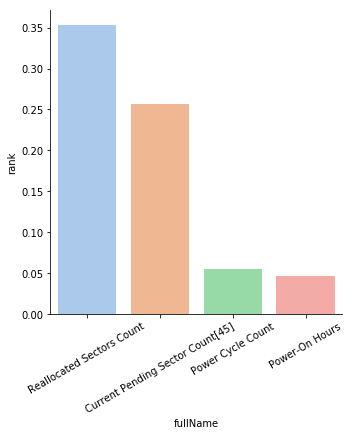

In [96]:
#plt.bar(featureRankSorted.rank,featureRankSorted.name,color='blue')
import seaborn as sns
g = sns.catplot(x="fullName", y="rank",kind = "bar", palette = "pastel",data=featureRankSorted[:4]);
g.set_xticklabels(rotation=30)
#plt.show()

Confusion matrix, logistic regression
[[4124796 6088776]
 [    186     440]]


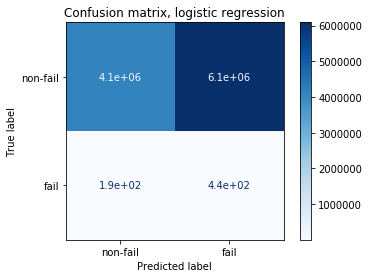

In [99]:
from sklearn.metrics import plot_confusion_matrix

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
title = "Confusion matrix, logistic regression"
normalize = None
class_names = ['non-fail','fail']
disp = plot_confusion_matrix(clf2, Xtest, Ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

Confusion matrix, Random forests
[[9902838  310734]
 [    169     457]]


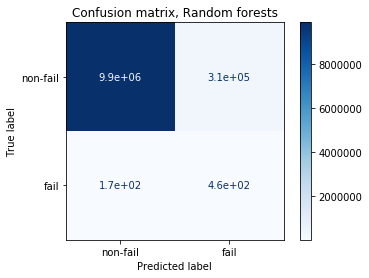

In [100]:
# Plot non-normalized confusion matrix
title = "Confusion matrix, Random forests"
normalize = None
class_names = ['non-fail','fail']
disp = plot_confusion_matrix(clfRF, Xtest, Ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

In [101]:
precisionRF, recallRF, thresholdsRF = precision_recall_curve(Ytest, clfRF.predict_proba(Xtest)[:,1]) 



In [102]:
fprRF, tprRF, thresholdsRF = metrics.roc_curve(Ytest, probabilityRF[:,1], pos_label=1)



Text(0.5, 1.0, 'ROC Random forests, failures, 0.89')

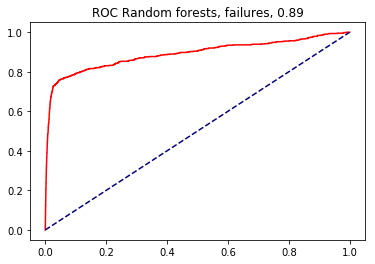

In [103]:
plt.plot(fprRF,tprRF, color='red')
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.title("ROC Random forests, failures, "+ str(round(auc(fprRF,tprRF),2)))

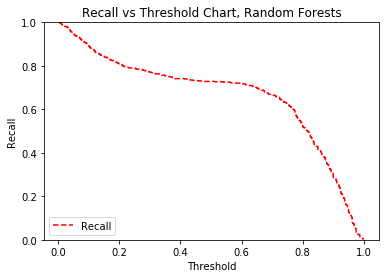

In [105]:
plt.title("Recall vs Threshold Chart, Random Forests")
#plt.plot(thresholdsRF, precisionRF[: -1], "b--", label="Precision")
plt.plot(thresholdsRF, recallRF[: -1], "r--", label="Recall")
plt.ylabel("Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.savefig("")

In [81]:
#feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)


In [82]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(Ytest, predictionRF))
print('Mean Squared Error:', metrics.mean_squared_error(Ytest, predictionRF))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Ytest, predictionRF)))

Mean Absolute Error: 0.029785206826811073
Mean Squared Error: 0.029785206826811073
Root Mean Squared Error: 0.17258391242178708


In [108]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Ytest, predictions3))
print('Mean Squared Error:', metrics.mean_squared_error(Ytest, predictions3))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Ytest, predictions3)))

Mean Absolute Error: 0.5717928123186959
Mean Squared Error: 0.5717928123186959
Root Mean Squared Error: 0.756169830341502


In [83]:
clfRF = randomForest(Xtrain_sc, y_train_res)
predictionRF = clfRF.predict(Xtest_sc)
print(classification_report(Ytest, predictionRF))
print(confusion_matrix(Ytest, predictionRF))

starting random forest
feature impoartance for RF
[2.52349230e-02 2.56181563e-02 3.74499914e-01 3.16629243e-02
 4.78831674e-02 6.54103485e-02 1.14570800e-02 2.69364412e-03
 2.78394309e-02 4.76056703e-02 3.34451524e-02 1.42186654e-02
 2.43541214e-01 1.12766835e-02 7.37191823e-03 2.83945205e-04
 2.99571628e-02]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98  10213572
           1       0.00      0.73      0.00       626

    accuracy                           0.97  10214198
   macro avg       0.50      0.85      0.49  10214198
weighted avg       1.00      0.97      0.98  10214198

[[9911202  302370]
 [    171     455]]


In [84]:
#yscore = clfRF.decision_path(Xtest)


In [112]:
#dfsampleSuccess = dfSuccess.sample(n = 100000-len(dfFailures))
dfsampleSuccess = dfSuccess
  
dfsampleFailure = dfFailures


In [114]:
dfBatch = pd.concat([dfsampleSuccess, dfsampleFailure], axis=0)
#dfBatch['modelType'] = dfBatch['modelType']
dfBatch = dstrain

In [115]:
dfBatch.columns

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized',
       'smart_2_raw', 'smart_3_normalized',
       ...
       'smart_252_normalized', 'smart_252_raw', 'smart_254_normalized',
       'smart_254_raw', 'smart_255_normalized', 'smart_255_raw', 'modelName',
       'index', 'modelType', 'modelType1'],
      dtype='object', length=133)

In [130]:
dfsampleSuccess = dfBatch[dfBatch.failure == 0]
  
dfsampleFailure = dfBatch[dfBatch.failure == 1]

In [131]:
Y = dfBatch[['failure']]

X = dfBatch[simpleFeatures]


X_train0 = X
y_train0 = Y

print("Number transactions X_train dataset: ", X_train0.shape)
print("Number transactions y_train dataset: ", y_train0.shape)


print("Current Time =", datetime.now().strftime("%H:%M:%S"))

X_train = X_train0.fillna(0)



Number transactions X_train dataset:  (100505, 17)
Number transactions y_train dataset:  (100505, 1)
Current Time = 17:18:10


In [132]:
def batchSample(dfsampleSuccess,dfsampleFailure,features):

    dfSuccessbatch = dfsampleSuccess.sample(n =100)
    dfFailurebatch = dfsampleFailure.sample(n = 100)


    dfBatch = pd.concat([dfSuccessbatch, dfFailurebatch], axis=0)

    #print(dfBatch[['failure']])


    X_batch = dfBatch[features].fillna(0)
    y_batch = dfBatch['failure']


    return X_batch,y_batch




In [133]:
def SDG(dfsampleSuccess,dfsampleFailure,features,iter):
    print(features)
    SDGmodel = linear_model.SGDClassifier(max_iter=5, tol=1e-12, loss='log',penalty='elasticnet')
    for i in range(0, iter):
        x_batch, y_batch=batchSample(dfsampleSuccess,dfsampleFailure,features)
            #print(y_batch)
        clf = SDGmodel.partial_fit(x_batch, y_batch,classes=np.unique(y_batch))
    return clf

In [134]:
#Xtest.columns
dfBatch.columns

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized',
       'smart_2_raw', 'smart_3_normalized',
       ...
       'smart_252_normalized', 'smart_252_raw', 'smart_254_normalized',
       'smart_254_raw', 'smart_255_normalized', 'smart_255_raw', 'modelName',
       'index', 'modelType', 'modelType1'],
      dtype='object', length=133)

In [1]:
#print('Starting SGD...')
#print("Current Time =", datetime.now().strftime("%H:%M:%S"))
#simpleFeaturesHist = ['capacity_bytes','smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw','smart_200_raw', 'smart_240_raw','smart_241_raw']



#clf = SDG(dfsampleSuccess,dfsampleFailure,simpleFeatures,200)


#prediction = clf.predict(Xtest)
#print(confusion_matrix(Ytest,prediction))
#print(classification_report(Ytest, prediction, zero_division=1))

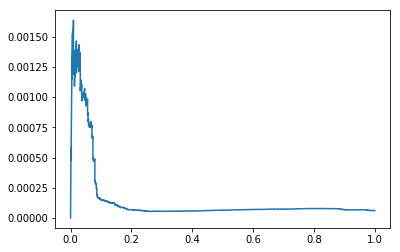

In [136]:
plt.plot( recall[: -1], precision[: -1], label="Precision v recall")

In [137]:
featureStat = (dfsampleFailure[simpleFeaturesHist] - dfsampleFailure[simpleFeaturesHist].mean()) / dfsampleFailure[simpleFeaturesHist].std()  

In [138]:
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

In [141]:
def runSVM(X_train_res, y_train_res):
    clf = svm.SVC().fit(X_train_res, y_train_res)
    return clf

In [ ]:
#clf = runSVM(X_train_res, y_train_res)
#prediction = clf.predict(Xtest)
#print(confusion_matrix(Ytest,prediction))
#print(classification_report(Ytest, prediction, zero_division=1))

In [ ]:
from imblearn.under_sampling import ClusterCentroids

In [17]:
def regressionUnderSampling(X, y):
    print('calculate under-sampling')

    cc = ClusterCentroids(random_state=0)
    X_resampled, y_resampled = cc.fit_resample(X, y)

    print('Results with under-sampling')
    return X_resampled, y_resampled